## Load Data

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random

# To ignore warnings caused by tensorflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train = mnist.train.images, mnist.train.labels
X_valid, y_valid = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print("Train Set: {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set: {} samples".format(len(X_test)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Image Shape: (28, 28, 1)
Train Set: 55000 samples
Validation Set: 5000 samples
Test Set: 10000 samples


### Reshape image to fit the LeNet arch
The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.However, the LeNet architecture only accepts 32x32xC images.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data(28+2+2=32).

In [3]:
X_train = np.pad(X_train, ((0,0), (2,2), (2,2), (0,0)), 'constant')
X_valid = np.pad(X_valid, ((0,0), (2,2), (2,2), (0,0)), 'constant')
X_test = np.pad(X_test, ((0,0), (2,2), (2,2), (0,0)), 'constant')

print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


## Visualize Data

8


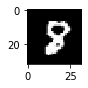

In [4]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

## Preprocess Data

In [5]:
X_train, y_train = shuffle(X_train, y_train)

## Setup Tensorflow
##### Epochs:
How many times to run my training data through the network. In general the more epochs ,the better my model will train but also the longer training will take.
##### Batch Size:
How many training images to run through the network at a time. The larger the batch size the faster my model will train, but my processor may have a memory limit on how large a batch it can run.

In [6]:
EPOCHS = 10
BATCH_SIZE = 128

## Implement LeNet-5

In [10]:
def LeNet(x):
    mu = 0
    sigma = 0.1
    
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    fc0 = flatten(conv2)
    
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc0, fc1_w), fc1_b)
    fc1 = tf.nn.relu(fc1)
    
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, fc2_w), fc2_b)
    fc2 = tf.nn.relu(fc2)
    
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 10), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    fc3 = tf.add(tf.matmul(fc2, fc3_w), fc3_b)
    return fc3

## Features and Labels
I initialize the batch size to None which allows the placeholder to later accept a batch of any size, and I set the image dimensions to 32x32x1. In this case, my labels come through withh sparse variables which just means that they're integers. They aren't one-hot encoded yet.

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

## Training Pipeline

In [13]:
lr = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training = optimizer.minimize(loss)

## Model Evaluation
The evaluation pipeline I create here will evaluate how good the model is.

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = x_data[offset: offset+BATCH_SIZE]
        batch_y = y_data[offset:offset+BATCH_SIZE]
        batch_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += batch_accuracy * len(batch_x)
    return total_accuracy / num_examples        